# Super-Resolution

## Data Prep

In [3]:
import os
import torch
import rasterio
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
import matplotlib.pyplot as plt
from transformers import Swin2SRImageProcessor, Swin2SRForImageSuperResolution
from torch.optim import Adam
from tqdm import tqdm
from PIL import Image
import numpy as np

hr_size = 128 

class SRDataset(Dataset):
    def __init__(self, data_paths, lr_size=(64, 64), hr_size=(128, 128)):
        self.data_paths = data_paths
        self.lr_size = lr_size
        self.hr_size = hr_size

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        image_path = self.data_paths[idx]
        
        img = Image.open(image_path).convert('RGB')  # Ensure RGB format
        
        img = np.array(img) 
        
        # Resize low-res and high-res images
        lr_img = resize(img, self.lr_size, anti_aliasing=True, preserve_range=True)  # Resize to 64x64
        hr_img = resize(img, self.hr_size, anti_aliasing=True, preserve_range=True)  # Resize to 128x128

        # Normalize images to [0, 1]
        lr_img = lr_img / 255.0
        hr_img = hr_img / 255.0

        # Convert to tensors and add RGB channels
        lr_tensor = torch.tensor(lr_img, dtype=torch.float32).permute(2, 0, 1)  # [3, 64, 64]
        hr_tensor = torch.tensor(hr_img, dtype=torch.float32).permute(2, 0, 1)  # [3, 128, 128]


        return lr_tensor, hr_tensor, image_path.split("\\")[-1].split(".")[0]


# Function to filter 120x120 images
def filter_120x120_images(datasetPath):
    imagePaths = []
    for root, dirs, files in os.walk(datasetPath):
        for file in files:
            image_path = os.path.join(root, file)
            with rasterio.open(image_path) as src:
                # Check if the image is 120x120
                if src.width == 120 and src.height == 120:
                    imagePaths.append(image_path)
                else:
                    print(f"Skipping image {file} with size {src.width}x{src.height}")

    return imagePaths

datasetPath = r"SampleDataset"
imagePaths = filter_120x120_images(datasetPath)

dataset = SRDataset(imagePaths, lr_size=(64, 64), hr_size=(128, 128)) 
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

print(len(dataset))


504


## Training

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import filters
from transformers import Swin2SRImageProcessor, Swin2SRForImageSuperResolution
from tqdm import tqdm

# Load Swin2SR model and processor
processor = Swin2SRImageProcessor.from_pretrained("caidas/swin2SR-classical-sr-x2-64")
model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x2-64")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Swin2SRForImageSuperResolution(
  (swin2sr): Swin2SRModel(
    (first_convolution): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (embeddings): Swin2SREmbeddings(
      (patch_embeddings): Swin2SRPatchEmbeddings(
        (projection): Conv2d(180, 180, kernel_size=(1, 1), stride=(1, 1))
        (layernorm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swin2SREncoder(
      (stages): ModuleList(
        (0-5): 6 x Swin2SRStage(
          (layers): ModuleList(
            (0-5): 6 x Swin2SRLayer(
              (attention): Swin2SRAttention(
                (self): Swin2SRSelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=6, bias=False)
                  )
                  (que

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


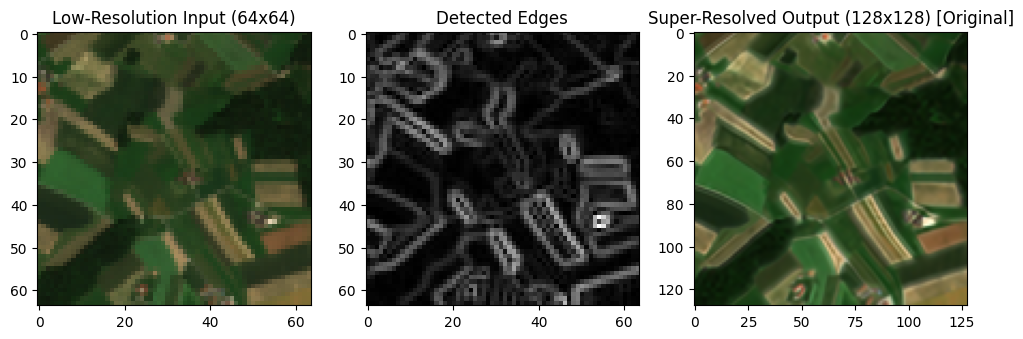

In [8]:
import torch.nn.functional as F  # For interpolation
import matplotlib.pyplot as plt
from skimage import filters
import torchvision.transforms as T

# Define Gaussian blur with a kernel size
blur = T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))

# Function to detect edges
def detect_edges(image_tensor):
    image_np = image_tensor.cpu().permute(1, 2, 0).numpy()
    gray_img = image_np.mean(axis=2)
    edges = filters.sobel(gray_img)
    edge_tensor = torch.tensor(edges, dtype=torch.float32).unsqueeze(0)  # Shape [1, H, W]
    return edge_tensor

# Function to combine edges with low-resolution image (for intermediate SR stages)
def combine_image_with_features(image_tensor, feature_tensor):
    # Normalize image and feature tensors
    image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
    feature_tensor = (feature_tensor - feature_tensor.min()) / (feature_tensor.max() - feature_tensor.min())
    
    # Add edges to the image with a small weight
    combined_tensor = image_tensor + (0.3 * feature_tensor)
    return combined_tensor

# Super-resolution guided by edge detection
def feature_guided_super_resolution(lr_tensor):
    edge_tensor = detect_edges(lr_tensor[0])  # Detect edges in the 64x64 image
    edge_tensor = edge_tensor.to(device)
    
    # Combine the LR image (64x64) with edges for intermediate SR
    combined_tensor = combine_image_with_features(lr_tensor[0], edge_tensor)

    # Perform the first stage of super-resolution (64x64 -> 128x128)
    with torch.no_grad():
        inputs = {'pixel_values': combined_tensor.unsqueeze(0).to(device)}
        outputs = model(**inputs)
        sr_image = outputs.reconstruction  # Direct 128x128 super-resolved output

    # Apply Gaussian blur to smooth the final image and reduce the edge highlights
    sr_image = blur(sr_image)

    return sr_image, edge_tensor

# Visualization function
def visualize_images_with_features(lr_image, final_sr_image, edge_tensor):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    lr_img = lr_image.permute(1, 2, 0).cpu().numpy()
    plt.imshow(lr_img)
    plt.title("Low-Resolution Input (64x64)")
    
    plt.subplot(1, 3, 2)
    plt.imshow(edge_tensor.cpu().squeeze(), cmap='gray')
    plt.title("Detected Edges")

    plt.subplot(1, 3, 3)
    final_sr_img = final_sr_image[0].permute(1, 2, 0).cpu().detach().numpy()
    plt.imshow(final_sr_img)
    plt.title("Super-Resolved Output (128x128) [Original]")

    plt.show()

# Apply 2x SR with edge detection
for batch_idx, (lr_tensor, hr_tensor, img_path) in enumerate(dataloader):
    lr_tensor = lr_tensor.to(device)
    
    # 64x64 to 128x128 super-resolution
    final_sr_image, edge_tensor = feature_guided_super_resolution(lr_tensor)

    # Visualize the 64x64 input and 128x128 output with edges
    visualize_images_with_features(lr_tensor[0], final_sr_image, edge_tensor)

    break  # Stop after one batch for demonstration


  0%|          | 0/252 [00:00<?, ?it/s]

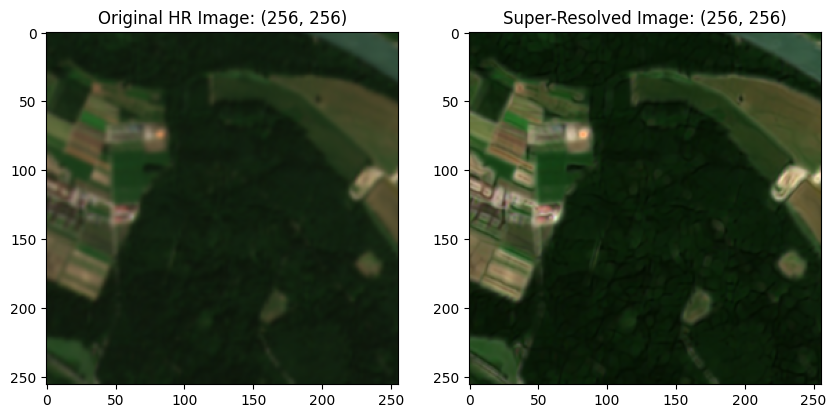

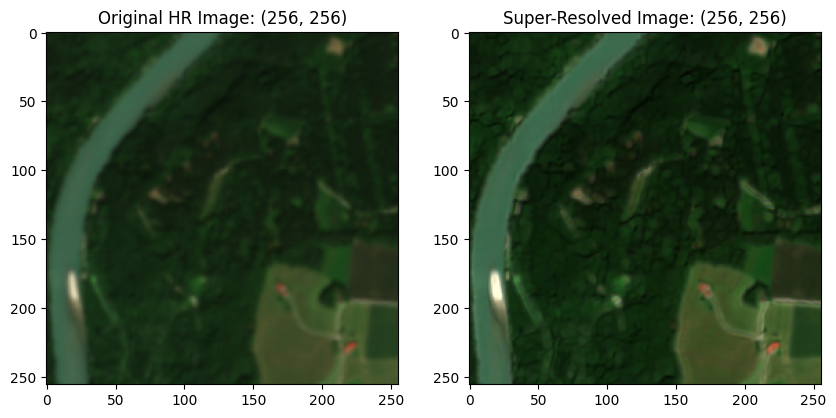

  0%|          | 0/252 [00:01<?, ?it/s]

Average PSNR: 29.1184
Average SSIM: 0.8886
Average MSE: 0.00136675


In [19]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

def super_resolve_images(dataloader, model, device):
    model.eval()
    psnr_scores = []
    ssim_scores = []
    mse_scores = []

    for batch_idx, (lr_tensor, hr_tensor, img_path) in enumerate(tqdm(dataloader)):
        hr_tensor = hr_tensor.to(device)

        for i in range(hr_tensor.shape[0]):
            hr_image = hr_tensor[i]

            # Edge detection and combination (assuming these functions are defined elsewhere)
            edge_tensor = detect_edges(hr_image).to(device)
            combined_tensor = combine_image_with_features(hr_image, edge_tensor)

            # Super-resolution pass
            with torch.no_grad():
                inputs = {'pixel_values': combined_tensor.unsqueeze(0)}
                outputs = model(**inputs)
                final_sr_image = outputs.reconstruction

            # Resize original HR image from 128x128 to 256x256 for comparison
            resized_hr_image = F.interpolate(hr_image.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)

            # Move images to CPU and convert to numpy arrays
            hr_img_np = resized_hr_image.cpu().permute(1, 2, 0).numpy()
            sr_img_np = final_sr_image[0].cpu().permute(1, 2, 0).detach().numpy()

            # Ensure the images are in the correct range [0, 1]
            hr_img_np = np.clip(hr_img_np, 0, 1)
            sr_img_np = np.clip(sr_img_np, 0, 1)

            # Calculate PSNR
            psnr_value = peak_signal_noise_ratio(hr_img_np, sr_img_np, data_range=1.0)
            psnr_scores.append(psnr_value)

            # Calculate SSIM
            ssim_value = structural_similarity(hr_img_np, sr_img_np, channel_axis=2, data_range=1.0, win_size=7)
            ssim_scores.append(ssim_value)

            # Calculate MSE
            mse_value = mean_squared_error(hr_img_np, sr_img_np)
            mse_scores.append(mse_value)

            # Visualization (optional, you can comment this out if not needed)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(hr_img_np)
            plt.title(f"Original HR Image: {hr_img_np.shape[:2]}")
            plt.subplot(1, 2, 2)
            plt.imshow(sr_img_np)
            plt.title(f"Super-Resolved Image: {sr_img_np.shape[:2]}")
            plt.show()

        # Stop after one batch for demonstration
        break

    # Calculate average metrics
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    avg_mse = np.mean(mse_scores)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average MSE: {avg_mse:.8f}")

    return hr_img_np, sr_img_np, avg_psnr, avg_ssim, avg_mse

hr_img, sr_img, avg_psnr, avg_ssim, avg_mse = super_resolve_images(dataloader, model, device)